In [5]:
from dotenv import load_dotenv

load_dotenv()

True

In [6]:
import requests

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [7]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

### Load ground truth

In [8]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [9]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [10]:
doc_idx = {d['id']: d for d in documents}

doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

### Index the data

In [11]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/Users/zaahirdawood/Documents/llm-zoomcamp/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/zaahirdawood/Documents/llm-zoomcamp/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [12]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [13]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + " " + text)
    
    es_client.index(index= index_name, document= doc)
    

100%|██████████| 948/948 [02:06<00:00,  7.47it/s]


### Retrieval

In [14]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [15]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

### RAG Flow

In [16]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [17]:
from openai import OpenAI
# from groq import Groq
import os

api_key = os.getenv('OPENAI_API_KEY')

client = OpenAI(api_key= api_key)

def llm(prompt, model='gpt-4o-mini'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [18]:
# previously: rag(query: str) -> str
def rag(query: dict, model= 'gpt-4o-mini') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [19]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [20]:
rag(ground_truth[10])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'Yes, sessions are recorded, so if you miss one, you won’t miss anything. You will also be able to ask your questions for office hours in advance, and they will be covered during the live stream.'

In [21]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

### Cosine Similarity metric

In [22]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

np.float32(0.759117)

In [23]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [24]:
len(ground_truth)

1830

In [25]:
answers = {}

In [26]:

for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    } # haven't run this to avoid hitting rate limit that was reached on the first attempt

100%|██████████| 1830/1830 [45:32<00:00,  1.49s/it] 


In [31]:
import pandas as pd

df_gpt_4o = pd.DataFrame(answers.values())

In [32]:
df_gpt_4o.sample(n=5).to_dict(orient='records')

[{'answer_llm': 'To solve the ValueError related to having only 0\'s in the churn column, you need to address the issue of your churn column containing only one class. Specifically, it seems that the way you are encoding the churn column is resulting in only 0\'s. The error message states: "This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0."\n\nYou can fix this issue by ensuring that your churn column is correctly encoded to include both classes. Currently, your code seems to be set up to only represent \'yes\' as 1 and everything else as 0. If there are no \'yes\' responses in your data, this will lead to the problem you are encountering.\n\nOne way to resolve it is to ensure that your data has a balance between classes. You may consider duplicating instances of the \'yes\' class if they are underrepresented or adjusting your dataset to include samples of both classes. After doing this, rerun your accuracy calculations and the error r

In [29]:
len(answers)

1830

In [34]:
results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [35]:
results_gpt4o

[{'answer_llm': 'You can sign up for the course by visiting the course page at http://mlzoomcamp.com/.',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 {'answer_llm': 'You can sign up by visiting the course GitHub repository, where you will find the link. Here it is: [https://airtable.com/shryxwLd0COOEaqXo](https://airtable.com/shryxwLd0COOEaqXo).',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for ou

In [37]:
df_gpt_4o.to_csv('/Users/zaahirdawood/Documents/llm-zoomcamp/04-monitoring/data/results-gpt4o.csv',index=False)

In [39]:
!head data/results-gpt4o.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


answer_llm,answer_orig,document,question,course
You can sign up for the course by visiting the course page at http://mlzoomcamp.com/.,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"You can sign up by visiting the course GitHub repository, where you will find the link. Here it is: [https://airtable.com/shryxwLd0COOEaqXo](https://airtable.com/shryxwLd0COOEaqXo).","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for insp

In [42]:
response = rag(ground_truth[0],model='gpt-3.5-turbo')
print(_)

You can sign up for the course by going to the course page at http://mlzoomcamp.com/. You can start going through the course materials by scrolling down on the page or by using this link: http://mlzoomcamp.com/#syllabus.


In [49]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [46]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [47]:
process_record(ground_truth[10])

{'answer_llm': "Yes, sessions are recorded so you won't miss anything. You can also ask your questions for office hours in advance and they will be covered during the live stream.",
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [ ]:
results_gpt35 = map_progress(pool, ground_truth, process_record) #hits rate limit for the day

In [52]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)
    

In [53]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 1830/1830 [01:17<00:00, 23.70it/s]


In [55]:
df_gpt_4o['cosine'] = similarity

In [58]:
df_gpt_4o.iloc[3].to_dict()

{'answer_llm': 'The context provided does not mention a specific GitHub repository for the sign-up link for the course. Therefore, based on the available information, I cannot confirm whether there is a GitHub repository for that purpose.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Does this course have a GitHub repository for the sign-up link?',
 'course': 'machine-learning-zoomcamp',
 'cosine': -0.02200973778963089}

In [60]:
df_gpt_4o['cosine'].describe()

count    1830.000000
mean        0.679869
std         0.216584
min        -0.138094
25%         0.594977
50%         0.735369
75%         0.833037
max         0.982869
Name: cosine, dtype: float64

In [74]:
!wget https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt35-cosine.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2024-07-27 14:44:42--  https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/04-monitoring/data/results-gpt35-cosine.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1513668 (1.4M) [text/plain]
Saving to: ‘results-gpt35-cosine.csv’

results-gpt35-cosin 100%[===================>]   1.44M  1.16MB/s    in 1.2s    

2024-07-27 14:44:43 (1.16 MB/s) - ‘results-gpt35-cosine.csv’ saved [1513668/1513668]



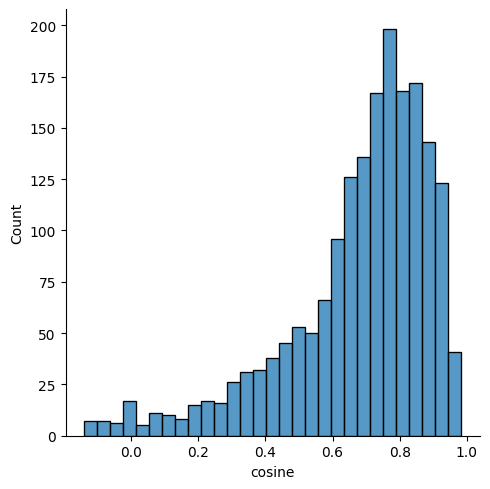

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(df_gpt_4o['cosine'])

plt.show()

In [76]:
df_gpt_35 = pd.read_csv('/Users/zaahirdawood/Documents/llm-zoomcamp/04-monitoring/data/results-gpt35-cosine.csv')

In [77]:
df_gpt_35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

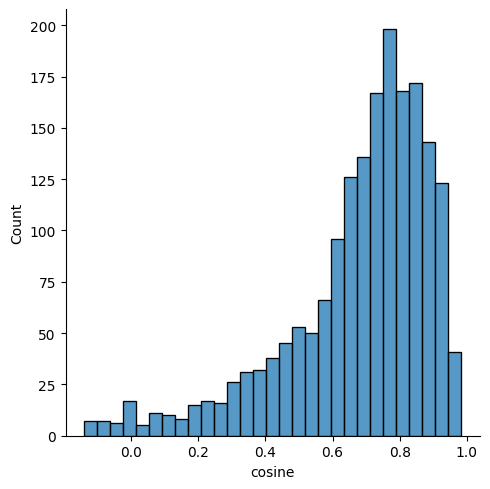

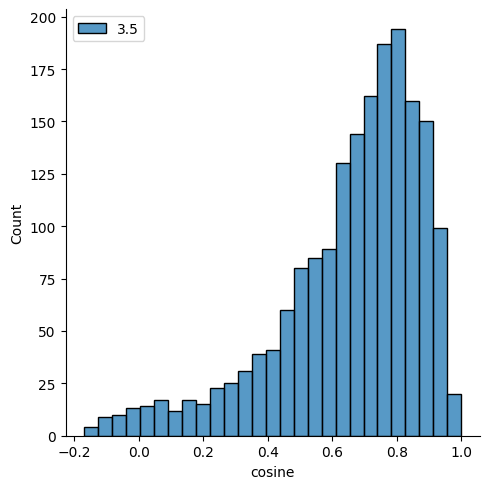

In [80]:
sns.displot(df_gpt_4o['cosine'],label='4o')
sns.displot(df_gpt_35['cosine'],label='3.5')

plt.legend()
plt.show()

### LLM as Judge

In [132]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [121]:
sample = df_gpt_4o.sample(n=150, random_state=1)

In [134]:
samples = sample.to_dict(orient='records')

In [127]:
answer = llm(prompt,model='gpt-4o-mini')

In [128]:
import json 

json.loads(answer)

{'Relevance': 'PARTLY_RELEVANT',
 'Explanation': 'The generated answer correctly identifies Annaliese Bronz as the person who suggested showcasing progress through LinkedIn posts. However, it does not fully capture the context of the original answer, which also discusses how to list experiences related to DataTalksClub and provides additional context about not categorizing it as official job experience. Thus, while it is related to the question, it lacks completeness in addressing the broader context of the original answer.'}

In [135]:
answers = []
for rec in tqdm(samples):
    prompt = prompt1_template.format(**rec)
    answer = llm(prompt,model='gpt-4o-mini')
    answers.append(answer)

100%|██████████| 150/150 [03:29<00:00,  1.39s/it]


In [136]:
json_answers = []

for answer in answers:
    json_answer = json.loads(answer)
    json_answers.append(json_answer)

In [137]:
json_answers[0]

{'Relevance': 'RELEVANT',
 'Explanation': "The generated answer directly provides the syntax for using `precision_recall_fscore_support` in Python, which aligns perfectly with the content of the original answer. Both answers include the same code snippet and explain the function's usage, maintaining the same context and example, thereby making it fully relevant."}

In [138]:
df_answers = pd.DataFrame(json_answers)

In [139]:
rel = df_answers.Relevance

In [140]:
rel.value_counts()

Relevance
RELEVANT           125
PARTLY_RELEVANT     17
NON_RELEVANT         8
Name: count, dtype: int64

In [141]:
df_answers[df_answers.Relevance == "NON_RELEVANT"].to_dict(orient='records')

[{'Relevance': 'NON_RELEVANT',
  'Explanation': 'The generated answer addresses a different issue related to Scikit-Learn version conflicts, which is not mentioned in the original answer. The original answer specifically discusses an error related to a Docker build and Python wheel compatibility, while the generated answer focuses on pip version errors related to Scikit-Learn, making it irrelevant to the original context.'},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': "The generated answer discusses resolving a NotSupportedError related to protobuf versions and workarounds for a specific library, which is unrelated to the original error concerning the use of 'eb local' with Docker platforms. The original answer provides specific steps for configuring Elastic Beanstalk environments, while the generated answer does not address these steps or the context of 'eb local'."},
 {'Relevance': 'NON_RELEVANT',
  'Explanation': 'The generated answer does not address the question about the alte